Importing packages

In [8]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

In [18]:
df = pd.read_csv('Churn_Modelling.csv')
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [19]:
# target variable (Exited) is balanced or imbalanced
df['Exited'].value_counts()
df['Exited'].value_counts(normalize=True) * 100


Exited
0    79.63
1    20.37
Name: proportion, dtype: float64

In [20]:
# Convert binary columns to 0/1 if not already
binary_cols = ['Gender', 'IsActiveMember', 'HasCrCard']

# Example: Male=1, Female=0 for Gender
df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0})

# If IsActiveMember and HasCrCard are already 0/1, skip; else map similarly
# df['IsActiveMember'] = df['IsActiveMember'].map({'Yes':1, 'No':0})
# df['HasCrCard'] = df['HasCrCard'].map({'Yes':1, 'No':0})

#  One-Hot Encode Geography
df = pd.get_dummies(df, columns=['Geography'], drop_first=True)

#  Separate features and target
X = df.drop('Exited', axis=1)  # Features
y = df['Exited']               # Target

#  Train-test split (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Check the result
print("Features after preprocessing:")
print(X_train.head())


Features after preprocessing:
      RowNumber  CustomerId  ... Geography_Germany  Geography_Spain
9136       9137    15688984  ...             False            False
6410       6411    15762351  ...             False             True
2607       2608    15814209  ...             False            False
3201       3202    15637593  ...             False            False
3330       3331    15657439  ...             False            False

[5 rows x 14 columns]


In [21]:
# dropping col as using logistic regression which only works on numeric data
df = df.drop(columns=['Surname'], errors='ignore')


In [22]:
# training data using logistic regression
X = df.drop('Exited', axis=1)
y = df['Exited']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

model = LogisticRegression()
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [23]:
y_pred = model.predict(X_test)          # Predicted classes (0 or 1)
y_prob = model.predict_proba(X_test)[:,1]  # Probability of exit


In [24]:
#  check model performance
print("Accuracy of logistic regression:", accuracy_score(y_test, y_pred))


Accuracy of logistic regression: 0.7963333333333333


In [25]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      1.00      0.89      2389
           1       0.00      0.00      0.00       611

    accuracy                           0.80      3000
   macro avg       0.40      0.50      0.44      3000
weighted avg       0.63      0.80      0.71      3000



In [11]:
print(confusion_matrix(y_test, y_pred))

[[2389    0]
 [ 611    0]]


Insight's:
 -The model is completely failing to detect customers who exited (class 1).
 -2389 customers who stayed were correctly predicted.
 -611 customers who exited were ALL missed.
 -The model never predicts class 1 even once
 As dataset is imbalanced.

In [12]:
# Use class_weight='balanced' in Logistic Regression
# This tells the model to pay equal attention to both classes.

model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]


In [13]:
model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [14]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

In [15]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.5276666666666666
              precision    recall  f1-score   support

           0       0.84      0.51      0.63      2389
           1       0.24      0.61      0.34       611

    accuracy                           0.53      3000
   macro avg       0.54      0.56      0.49      3000
weighted avg       0.71      0.53      0.57      3000

[[1211 1178]
 [ 239  372]]


Insight's:
 -Model finally detects exited customers (Class 1)
Before:
Recall for 1 = 0.00 → model ignored churners completely

Now:
Recall for 1 = 0.61 → it correctly identifies 61% of customers who exited
 Improvement.

372 exited customers were correctly predicted
1211 stayed customers correctly predicted
1178 false positives (predicted exit but stayed)
239 false negatives (missed exits)

Earlier, it detected 0 exits — so a major step forward.

In [26]:
# Trying a better ML model
#RandomForest

rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [17]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.864
              precision    recall  f1-score   support

           0       0.87      0.97      0.92      2389
           1       0.81      0.43      0.56       611

    accuracy                           0.86      3000
   macro avg       0.84      0.70      0.74      3000
weighted avg       0.86      0.86      0.85      3000

[[2328   61]
 [ 347  264]]


Insight's:
 -Logistic Regression (unbalanced): 79%

 -Logistic Regression (balanced): 52%

Random Forest: 86%
 -The model is doing an excellent job identifying customers who stay.
 -When the model predicts someone will exit, it's right 81% of the time (great precision)
 -MUCH better than Logistic Regression (which had recall = 0%)

High overall accuracy, poor recall for minority class

In [18]:
!pip install xgboost
!pip install imbalanced-learn


  Using cached xgboost-3.0.5-py3-none-win_amd64.whl.metadata (2.1 kB)
Using cached xgboost-3.0.5-py3-none-win_amd64.whl (56.8 MB)


In [19]:
# scale_pos_weight helps handle class imbalance 
# (ratio = number of class 0 / number of class 1)
#Using XGBOOST 


scale = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

xgb = XGBClassifier(
    scale_pos_weight=scale,
    eval_metric='logloss',    # prevents warning
    random_state=42,
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8
)

xgb.fit(X_train, y_train)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [20]:
y_pred = xgb.predict(X_test)
y_prob = xgb.predict_proba(X_test)[:, 1]  # for ROC/threshold tuning


In [21]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.8296666666666667
              precision    recall  f1-score   support

           0       0.92      0.86      0.89      2389
           1       0.57      0.69      0.62       611

    accuracy                           0.83      3000
   macro avg       0.74      0.78      0.76      3000
weighted avg       0.85      0.83      0.84      3000

[[2066  323]
 [ 188  423]]


Balanced performance for minority class, slightly lower overall accuracy.

To Improve Recall (Catch more churners)
 -Use RandomForestClassifier(class_weight='balanced')

In [27]:
X = df.drop('Exited', axis=1)  #features
y = df['Exited']               #target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# -------------------------------
# Oversample minority class with SMOTE
# -------------------------------
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

# -------------------------------
# Train Random Forest with class_weight
# -------------------------------
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    class_weight={0:1, 1:3}  # increase weight for minority class
)
rf.fit(X_res, y_res)

# -------------------------------
# Predict probabilities & tune threshold automatically
# -------------------------------
y_probs = rf.predict_proba(X_test)[:,1]

# Find best threshold
thresholds = np.arange(0.1, 0.91, 0.01)
f1_scores = []

for t in thresholds:
    y_pred_t = (y_probs >= t).astype(int)
    f1_scores.append(f1_score(y_test, y_pred_t, pos_label=1))

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
print(f"Best Threshold: {best_threshold:.2f}")
print(f"Best F1-score for class 1: {f1_scores[best_idx]:.2f}")

# Predict using best threshold
y_pred_best = (y_probs >= best_threshold).astype(int)

# -------------------------------
# Evaluate the model
# -------------------------------
print("Classification Report:\n", classification_report(y_test, y_pred_best))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best))

Best Threshold: 0.43
Best F1-score for class 1: 0.60
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.85      0.88      1593
           1       0.54      0.67      0.60       407

    accuracy                           0.82      2000
   macro avg       0.72      0.76      0.74      2000
weighted avg       0.83      0.82      0.82      2000

Confusion Matrix:
 [[1361  232]
 [ 136  271]]


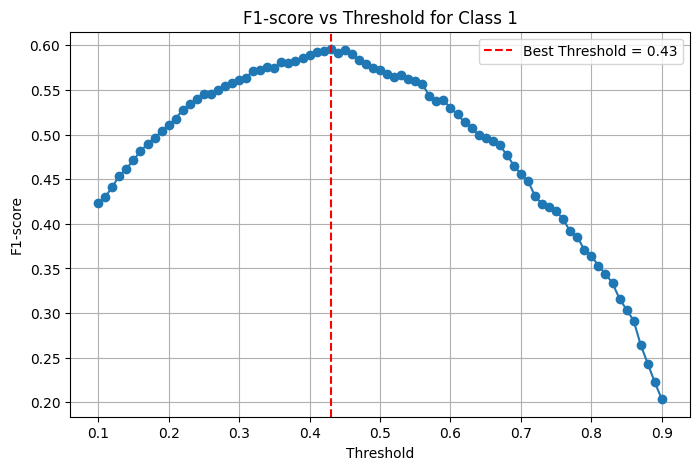

Best Threshold: 0.43
Best F1-score for class 1: 0.60


In [29]:
# Predicted probabilities for class 1
y_probs = rf.predict_proba(X_test)[:, 1]

# Thresholds to test
thresholds = np.arange(0.1, 0.91, 0.01)
f1_scores = []

# Calculate F1-score for each threshold
for t in thresholds:
    y_pred_t = (y_probs >= t).astype(int)
    f1_scores.append(f1_score(y_test, y_pred_t, pos_label=1))

# Find best threshold
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

# Plot
plt.figure(figsize=(8,5))
plt.plot(thresholds, f1_scores, marker='o')
plt.axvline(best_threshold, color='r', linestyle='--', label=f'Best Threshold = {best_threshold:.2f}')
plt.title('F1-score vs Threshold for Class 1')
plt.xlabel('Threshold')
plt.ylabel('F1-score')
plt.grid(True)
plt.legend()
plt.show()

print(f"Best Threshold: {best_threshold:.2f}")
print(f"Best F1-score for class 1: {best_f1:.2f}")

Any threshold lower than 0.43 → more predicted 1s, higher recall, lower precision → F1-score drops after 0.43.

Any threshold higher than 0.43 → fewer predicted 1s, lower recall → F1-score also drops.

Using this best threshold in predictions gives the most balanced performance for class 1

This shows Good balance:
  -improves minority class recall, decent overall accuracy

 -Recall improved from 0.43 → 0.67
 -F1-score for minority class = 0.60
 -Overall accuracy still reasonable at 82%

Balanced performance for both majority and minority classes

Detects more “true positives” for minority class than original Random Forest

Overall accuracy (82%)

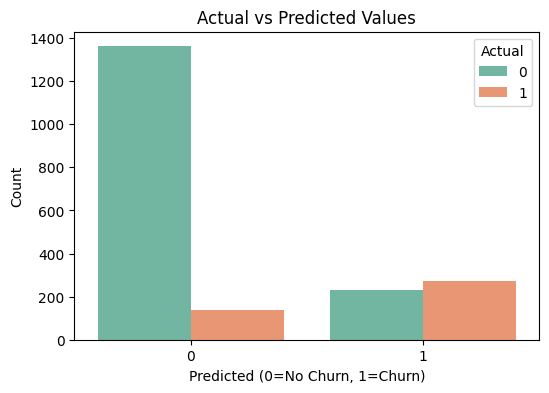

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(x=y_pred_best, hue=y_test, palette='Set2')
plt.title("Actual vs Predicted Values")
plt.xlabel("Predicted (0=No Churn, 1=Churn)")
plt.ylabel("Count")
plt.legend(title="Actual")
plt.show()


The model is stronger at predicting Class 0 (non-churners).

It still struggles with Class 1 (actual churners), which is common when there's class imbalance even after SMOTE.

Adjusting class weights or threshold tuning helped, but there is still room for improving recall for Class 1.

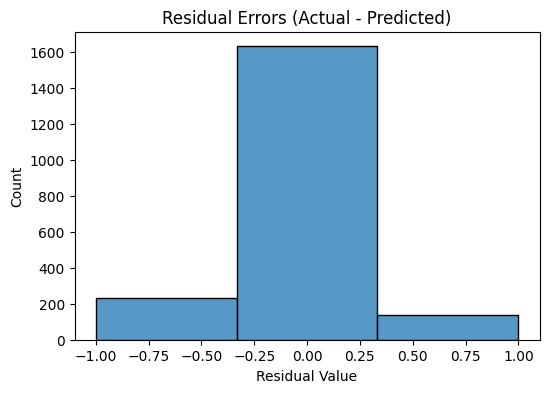

In [29]:
# Residuals
residuals = y_test - y_pred_best

plt.figure(figsize=(6,4))
sns.histplot(residuals, kde=False, bins=3)
plt.title("Residual Errors (Actual - Predicted)")
plt.xlabel("Residual Value")
plt.ylabel("Count")
plt.show()


Most values are 0, meaning the model predicts correctly most of the time.

There are some residuals at -1 → these are False Positives (predicted churn when they didn’t).

There are some residuals at +1 → these are False Negatives (actual churn but predicted not churn).